In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.vector_ar.var_model import VARResults, VARProcess

from statsmodels.tsa.vector_ar.svar_model import SVAR

# Ejemplo obtenido de Lutkepohl

## Importar los datos

In [2]:
mdata = sm.datasets.macrodata.load_pandas().data

mdata.index = pd.period_range('1959-03-31', '2009-09-30', freq='Q')

mdata1 = mdata[['realgdp','realcons','realinv']]
data1 = np.log(mdata1).diff().dropna()

mdata2 = mdata[['realgdp','m1']]
data2 = np.log(mdata2).diff().dropna()               
               
mdata3 = mdata[['realgdp','unemp']]
data3 = np.log(mdata3).diff().dropna()

# Ejemplo 2: GDP , M1


In [30]:
mdata2.columns

Index(['realgdp', 'm1'], dtype='object')

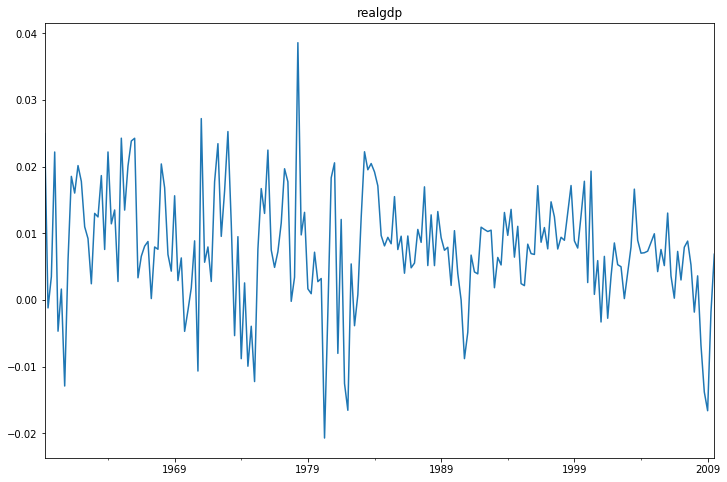

In [4]:
data2.realgdp.plot(figsize=(12,8),title='realgdp')
plt.show()

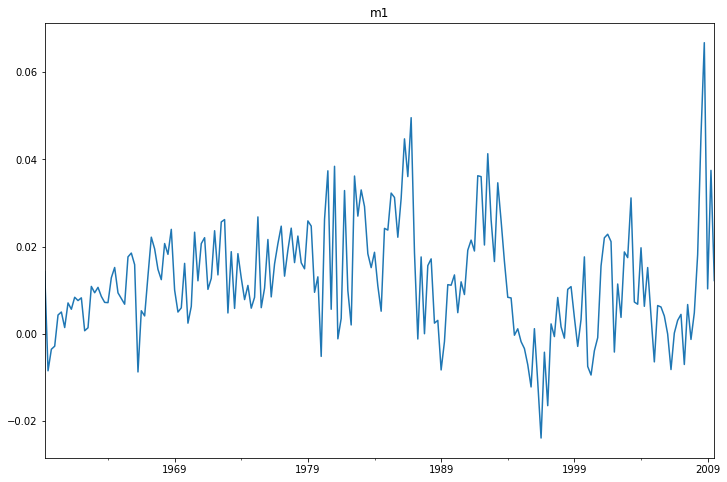

In [31]:
data2.m1.plot(figsize=(12,8),title='m1')
plt.show()

In [32]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [33]:
for name, column in data2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "realgdp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9729
 No. Lags Chosen       = 1
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "m1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8664
 No. Lags Chosen       = 7
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0023. Rejecting Null Hypothesis.
 => Series is Stationary.




In [34]:
# make a VAR model
model2 = VAR(data2)

In [35]:
model2.endog_names

['realgdp', 'm1']

In [36]:
model2.select_order(maxlags=12).summary()

,AIC,BIC,FPE,HQIC
0,-18.19,-18.16,1.260e-08,-18.18
1,-18.55,-18.45,8.792e-09,-18.51
2,-18.63,-18.46*,8.091e-09,-18.56*
3,-18.62,-18.38,8.172e-09,-18.53
4,-18.64,-18.33,8.024e-09,-18.52
5,-18.70*,-18.32,7.579e-09*,-18.55
6,-18.67,-18.22,7.827e-09,-18.49
7,-18.63,-18.12,8.095e-09,-18.42
8,-18.63,-18.05,8.104e-09,-18.40
9,-18.61,-17.96,8.303e-09,-18.34


In [37]:
results2 = model2.fit(2)
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Aug, 2020
Time:                     16:21:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.4607
Nobs:                     200.000    HQIC:                  -18.5589
Log likelihood:           1304.99    FPE:                8.14711e-09
AIC:                     -18.6256    Det(Omega_mle):     7.75454e-09
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.003693         0.001106            3.339           0.001
L1.realgdp         0.268657         0.069424            3.870           0.000
L1.m1             -0.049740         0.052253           -0.952         

In [12]:
results2.is_stable()

True

In [38]:
data2.tail()

,realgdp,m1
2008Q3,-0.006781,0.045361
2008Q4,-0.013805,0.066753
2009Q1,-0.016612,0.010286
2009Q2,-0.001851,0.037461
2009Q3,0.006862,0.012202


In [13]:
lag_order = results2.k_ar
results2.forecast(data2.values[-lag_order:], 10)

array([[0.00873166, 0.01919299],
       [0.00750952, 0.01498541],
       [0.00845222, 0.01499297],
       [0.00805069, 0.01402244],
       [0.00814181, 0.01361575],
       [0.00801656, 0.01326009],
       [0.00797061, 0.01303473],
       [0.00791067, 0.0128814 ],
       [0.00787025, 0.0127804 ],
       [0.00783811, 0.01271537]])

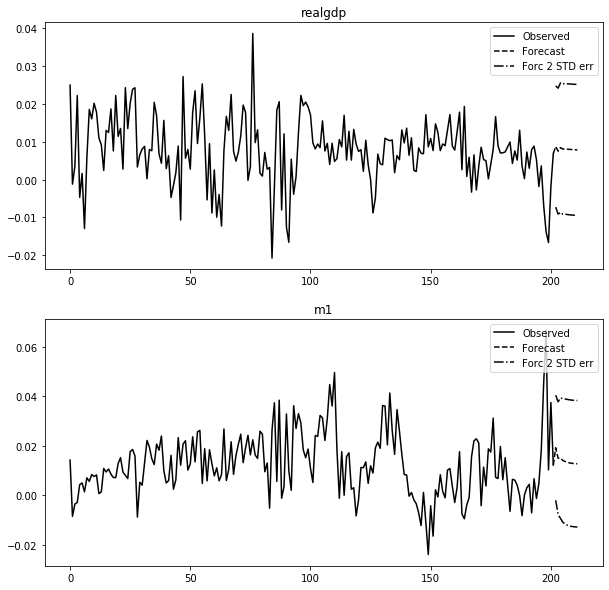

In [39]:
results2.plot_forecast(10)
plt.show()

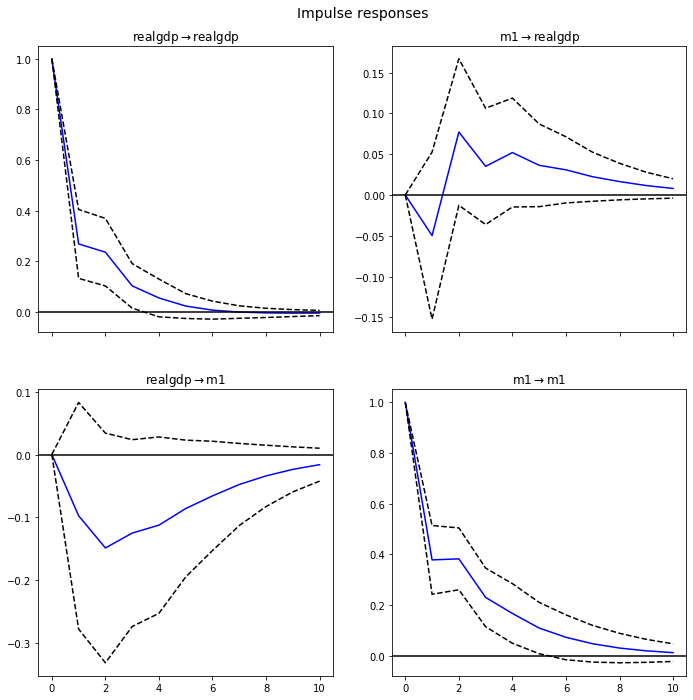

In [15]:
irf2=results2.irf(10)
irf2.plot()
plt.show()

In [16]:
results2.long_run_effects()

array([[ 1.66530094,  0.25605561],
       [-0.78648959,  2.45861276]])

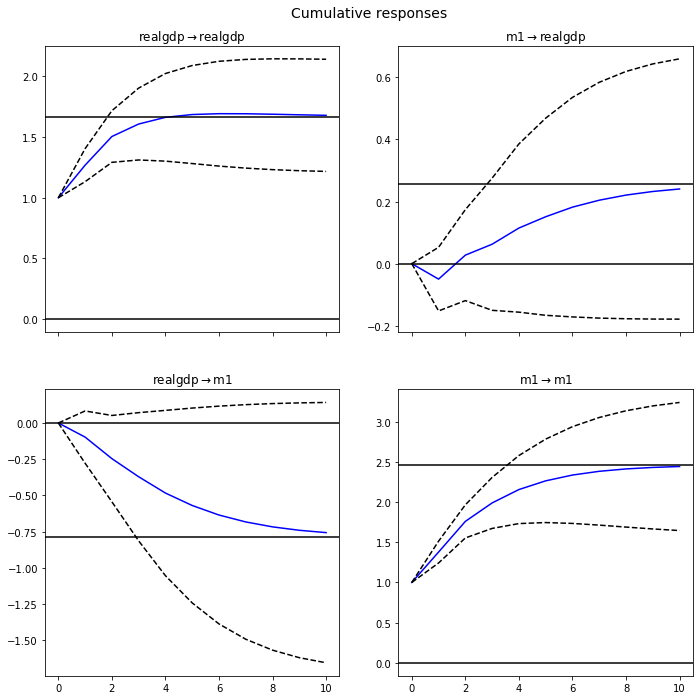

In [17]:
irf2.plot_cum_effects(orth=False)
plt.show()

In [19]:
fevd = results2.fevd(10)
fevd.summary()

FEVD for realgdp
      realgdp        m1
0    1.000000  0.000000
1    0.995996  0.004004
2    0.987103  0.012897
3    0.985367  0.014633
4    0.981380  0.018620
5    0.979433  0.020567
6    0.978036  0.021964
7    0.977303  0.022697
8    0.976906  0.023094
9    0.976710  0.023290

FEVD for m1
      realgdp        m1
0    0.005486  0.994514
1    0.013699  0.986301
2    0.026967  0.973033
3    0.034673  0.965327
4    0.040414  0.959586
5    0.043635  0.956365
6    0.045481  0.954519
7    0.046437  0.953563
8    0.046919  0.953081
9    0.047149  0.952851




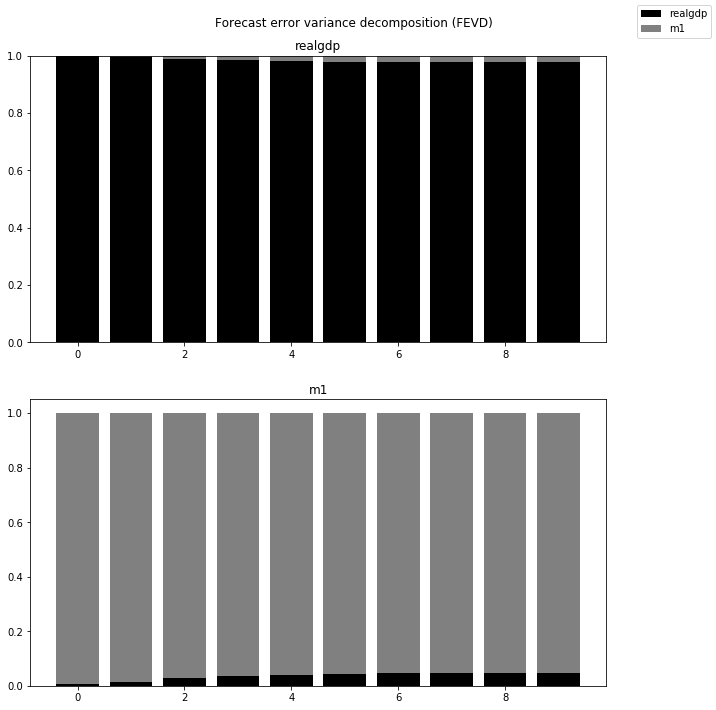

In [20]:
results2.fevd(10).plot()
plt.show()

In [21]:
results2.test_causality('realgdp', ['m1'], kind='f').summary()


Test statistic,Critical value,p-value,df
2.190,3.019,0.113,"(2, 390)"


In [40]:
#define structural inputs
A = np.asarray([[1, 'E'],[0, 1]])

B = np.asarray([['E', 0], [0, 'E']])

In [42]:
B

array([['E', '0'],
       ['0', 'E']], dtype='<U1')

In [43]:
A_guess = np.asarray([0.1])

B_guess = np.asarray([0.5, 0.5])

mymodel = SVAR(data2, svar_type='AB', A=A, B=B)

C:\Users\lfsanche\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


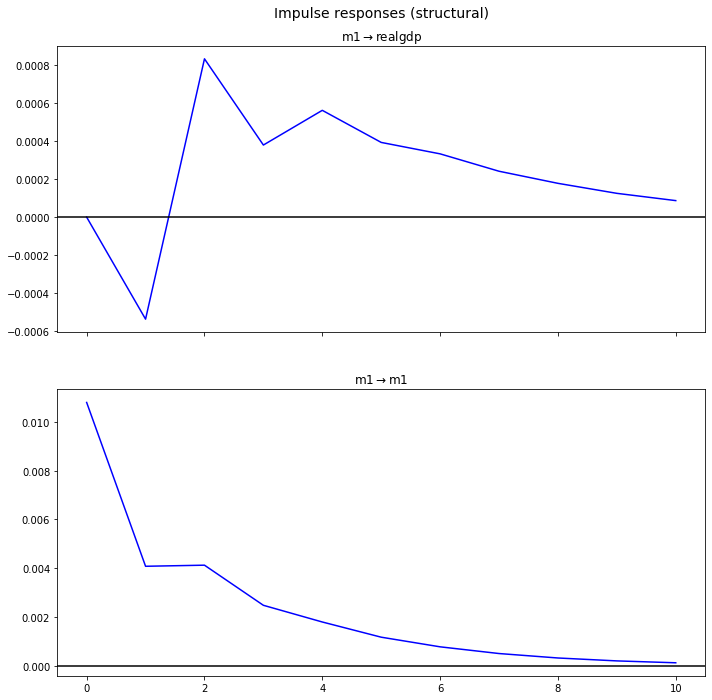

In [48]:
res = mymodel.fit(maxlags=2, maxiter=10000, maxfun=10000, solver='bfgs')

res.irf(periods=10).plot(impulse='m1', plot_stderr=False)

plt.show()


In [46]:
res.A

array([[1.        , 0.        ],
       [0.09814804, 1.        ]])

In [47]:
res.B

array([[0.00816305, 0.        ],
       [0.        , 0.01078761]])

In [28]:
res.long_run_effects()

array([[ 1.66530094,  0.25605561],
       [-0.78648959,  2.45861276]])

_____

# Ejumplo Numérico

La matriz de varianza y convarianza de los errores estiamdos $e$ es
$$\text{Eee'}=\Sigma=\left(\begin{array}{ll}
\sigma_{1}^{2} & \sigma_{12} \\
\sigma_{21} & \sigma_{2}^{2}
\end{array}\right)$$


Recordando que $e_{t}=B^{-1} \varepsilon_{\mathrm{t}}$, podemos escribir la matriz de varianza y covarianza de $e$ como:


$$E(ee')=E B^{-1} \varepsilon\varepsilon'\left(B^{-1}\right)'=B^{-1} E\left(\varepsilon \varepsilon'\right)\left(B^{-1}\right)'$$


Por lo que podemos recuperar la matriz de varianza y covarianza de $\varepsilon$

$$ E(\varepsilon\varepsilon')= BE(ee')B'$$

$$\left[\begin{array}{cc}
\operatorname{var}\left(\varepsilon_{1}\right) & 0 \\
0 & \operatorname{var}\left(\varepsilon_{2}\right)
\end{array}\right]=\left[\begin{array}{cc}
1 & b_{12} \\
b_{21} & 1
\end{array}\right]\left[\begin{array}{cc}
\sigma_{1}^{2} & \sigma_{12} \\
\sigma_{21} & \sigma_{2}^{2}
\end{array}\right]\left[\begin{array}{cc}
1 & b_{21} \\
b_{12} & 1
\end{array}\right]$$


_____

## Descomposicion de Choleski, FIR

Considere el siguiente modelo:
    
$$\left(\begin{array}{l}
y_{t} \\
z_{t}
\end{array}\right)=\left(\begin{array}{ll}
0.7 & 0.2 \\
0.2 & 0.7
\end{array}\right) \cdot\left(\begin{array}{l}
y_{t-1} \\
z_{1-1}
\end{array}\right)+\left(\begin{array}{l}
e_{1t} \\
e_{2 t}
\end{array}\right)$$    


Si $b_{12}=0$, podemos escribir los errores del modelo standard como 

$$\left[\begin{array}{cc}
\operatorname{var}\left(\varepsilon_{y}\right) & 0 \\
0 & \operatorname{var}\left(\varepsilon_{z}\right)
\end{array}\right]=\left[\begin{array}{cc}
1 & 0 \\
b_{21} & 1
\end{array}\right]\left[\begin{array}{cc}
0.5& 0.8 \\
0.8 & 0.5
\end{array}\right]\left[\begin{array}{cc}
1 & b_{21} \\
0 & 1
\end{array}\right]$$



Resol.viendo el sistema tenemos,

$$\begin{aligned}
\operatorname{var}\left(\varepsilon_{y}\right) &=0.5 \\
0 &=0.5 b_{21}+0.8 \\
0 &=0.5 b_{21}+0.8 \\
\operatorname{var}\left(\varepsilon_{z}\right) &=0.8 b_{21}^{2}+1.3 b_{21}+0.5
\end{aligned}$$


tenemos $b_{21}=-1.6$, $var(\varepsilon_z)=0.47$ y $var(\varepsilon_y)=0.5$
 

In [ ]:
# A1 =np.array([[0.7, 0.20], [0.2, 0.7]])
# A1

In [ ]:
# w, v = np.linalg.eig(A1)
# print(w,v)

In [ ]:
B = np.array([[1,0],[-1.6,1]])
B

In [ ]:
ε = np.array([0,1]).T
e = np.linalg.inv(B)@ε
# εy = np.array([1,0]).T
# ey=B@εy
e

In [ ]:
y = np.zeros(20) 
yc = np.zeros(20)

z = np.zeros(20) 
zc = np.zeros(20)


for i in range(0,20):

    y[i] = 0.7*y[i-1] + 0.2*z[i-1]+ e[0]*(i==0)
    
    yc[i] = yc[i-1] + y[i]
      
    z[i] = 0.2*y[i-1]+ 0.7*z[i-1]+ e[1]*(i==0)
    
    zc[i]= zc[i-1]+z[i]


In [ ]:
plt.plot(y,'b',label='y')
plt.plot(z,'r', label='z')
plt.legend()
plt.show()

In [ ]:
plt.plot(yc,'b',label='y')
plt.plot(zc,'r', label='z')
plt.legend()
plt.show()

## Descomposici'on Sims-Bernanke: restricci'on sobre coeficientes

Si $b_{12}=1$, podemos escribir los errores del modelo standard como 

$$\left[\begin{array}{cc}
\operatorname{var}\left(\varepsilon_{1}\right) & 0 \\
0 & \operatorname{var}\left(\varepsilon_{2}\right)
\end{array}\right]=\left[\begin{array}{cc}
1 & 1 \\
b_{21} & 1
\end{array}\right]\left[\begin{array}{cc}
0.5& 0.8 \\
0.8 & 0.5
\end{array}\right]\left[\begin{array}{cc}
1 & b_{21} \\
1 & 1
\end{array}\right]$$



Resol.viendo el sistema tenemos,

$$\begin{aligned}
\operatorname{var}\left(\varepsilon_{1}\right) &=2.6 \\
0 &=1.3 b_{21}+1.3 \\
0 &=1.3 b_{21}+1.3 \\
\operatorname{var}\left(\varepsilon_{2}\right) &=0.5 b_{21}^{2}+1.6 b_{21}+0.5
\end{aligned}$$


tenemos $b_{21}=-1$, $var(\varepsilon_z)=0.47$ y $var(\varepsilon_y)=2.6$
 

In [ ]:
B = np.array([[1,1],[-1,1]])
B

In [ ]:
ε = np.array([0,1]).T
e = np.linalg.inv(B)@ε
e

In [ ]:
y = np.zeros(20) 
yc = np.zeros(20)

z = np.zeros(20) 
zc = np.zeros(20)


for i in range(0,20):

    y[i] = 0.7*y[i-1] + 0.2*z[i-1]+ e[0]*(i==0)
    
    yc[i]=yc[i-1]+y[i]
      
    z[i] = 0.2*y[i-1]+ 0.7*z[i-1]+ e[1]*(i==0)
    zc[i]= zc[i-1]+z[i]

In [ ]:
plt.plot(y,'b',label='y')
plt.plot(z,'r', label='z')
plt.legend()
plt.show()

In [ ]:
plt.plot(yc,'b',label='y')
plt.plot(zc,'r', label='z')
plt.legend()
plt.show()

## Descomposicion Sims-Bernanke: restriccion de simetría

Si $b_{12}=b_{21}=-0.5$, podemos escribir los errores del modelo standard como 

$$\left[\begin{array}{cc}
\operatorname{var}\left(\varepsilon_{1}\right) & 0 \\
0 & \operatorname{var}\left(\varepsilon_{2}\right)
\end{array}\right]=\left[\begin{array}{cc}
1 & -0.5 \\
-0.5 & 1
\end{array}\right]\left[\begin{array}{cc}
0.5& 0.8 \\
0.8 & 0.5
\end{array}\right]\left[\begin{array}{cc}
1 & -0.5 \\
-0.5 & 1
\end{array}\right]$$



In [ ]:
B = np.array([[1,-0.5],[-0.5,1]])
B

In [ ]:
ε = np.array([0,1]).T
e=B@ε

In [ ]:
y = np.zeros(20) 
yc = np.zeros(20)

z = np.zeros(20) 
zc = np.zeros(20)


for i in range(0,20):

    y[i] = 0.7*y[i-1] + 0.2*z[i-1]+ e[0]*(i==0)
    
    yc[i]=yc[i-1]+y[i]
      
    z[i] = 0.2*y[i-1]+ 0.7*z[i-1]+ e[1]*(i==0)
    zc[i]= zc[i-1]+z[i]

In [ ]:
plt.plot(y,'b',label='y')
plt.plot(z,'r', label='z')
plt.legend()
plt.show()